<a href="https://colab.research.google.com/github/pallavigowda6789-tech/SolarEnergyPrediction/blob/main/Solar_Power_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


In [ ]:
dfs = []
for f in csv_files:
    file_path = os.path.join(data_folder, f)
    try:
        df = pd.read_csv(file_path, parse_dates=['DATE_TIME'])  # adjust date column if needed
        df['site_id'] = f.split('_')[0]  # optional site ID
        dfs.append(df)
    except Exception as e:
        print(f"Failed to read {f}: {e}")

if len(dfs) == 0:
    raise ValueError("No valid CSV files found!")

data = pd.concat(dfs, ignore_index=True)
print("Combined data shape:", data.shape)
display(data.head())




Combined data shape: (142917, 11)


/tmp/ipython-input-177924203.py:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(file_path, parse_dates=['DATE_TIME'])  # adjust date column if needed


,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,site_id,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,Plant,NaN,NaN,NaN,NaN
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,Plant,NaN,NaN,NaN,NaN
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,Plant,NaN,NaN,NaN,NaN
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,Plant,NaN,NaN,NaN,NaN
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,Plant,NaN,NaN,NaN,NaN


/tmp/ipython-input-177924203.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily = daily[daily['energy_kWh']>0].fillna(method='ffill')


In [ ]:
# 6️⃣ Basic Cleaning
data.rename(columns={
    'DATE_TIME':'timestamp',
    'DAILY_YIELD':'energy_kWh',
    'DC_POWER':'dc_power',
    'AC_POWER':'ac_power',
    'AMBIENT_TEMPERATURE':'temp_C',
    'MODULE_TEMPERATURE':'module_temp',
    'IRRADIATION':'ghi'
}, inplace=True)


In [ ]:
# Sort data
data = data.sort_values(['site_id','timestamp']).reset_index(drop=True)


In [ ]:
# Aggregate to daily
daily = data.groupby('site_id').resample('1D', on='timestamp').agg({
    'energy_kWh':'max',
    'dc_power':'mean',
    'ac_power':'mean',
    'temp_C':'mean',
    'module_temp':'mean',
    'ghi':'sum'
}).reset_index()


In [ ]:
# Fill missing and remove zero energy
daily = daily[daily['energy_kWh']>0].fillna(method='ffill')

In [ ]:
# Date features
daily['dayofyear'] = daily['timestamp'].dt.dayofyear
daily['month'] = daily['timestamp'].dt.month
daily['weekday'] = daily['timestamp'].dt.weekday

In [ ]:
# Lag features
daily = daily.sort_values(['site_id','timestamp'])
daily['ghi_prev'] = daily.groupby('site_id')['ghi'].shift(1)
daily['energy_prev'] = daily.groupby('site_id')['energy_kWh'].shift(1)
daily['temp_prev'] = daily.groupby('site_id')['temp_C'].shift(1)

In [ ]:
# Drop NaNs created by lag
daily = daily.dropna().reset_index(drop=True)


In [ ]:
# Features & target
feature_cols = ['ghi','ghi_prev','temp_C','temp_prev','module_temp','dc_power','ac_power',
                'dayofyear','month','weekday','energy_prev']
X = daily[feature_cols]
y = daily['energy_kWh']


In [ ]:
feature_cols = ['ghi','ghi_prev','temp_C','temp_prev',
                'module_temp','dc_power','ac_power',
                'dayofyear','month','weekday','energy_prev']

X = daily[feature_cols]
y = daily['energy_kWh']


In [ ]:
daily = daily.sort_values(['site_id','timestamp']).reset_index(drop=True)
split_ratio = 0.8
split_index = int(len(daily) * split_ratio)

train = daily.iloc[:split_index]
test  = daily.iloc[split_index:]

X_train = train[feature_cols]
y_train = train['energy_kWh']
X_test = test[feature_cols]
y_test = test['energy_kWh']

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (26, 11) Test shape: (7, 11)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42
)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=300, random_state=42)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

train_preds = rf.predict(X_train)
test_preds  = rf.predict(X_test)

print("Train R²:", r2_score(y_train, train_preds))
print("Test  R²:", r2_score(y_test, test_preds))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_preds)))
print("Test  RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))
print("Train MAE:", mean_absolute_error(y_train, train_preds))
print("Test  MAE:", mean_absolute_error(y_test, test_preds))


Train R²: 0.7775641650663279
Test  R²: -0.7691227426502911
Train RMSE: 395.0409342931591
Test  RMSE: 1379.6328798893883
Train MAE: 299.17314294117335
Test  MAE: 1179.5063314100128


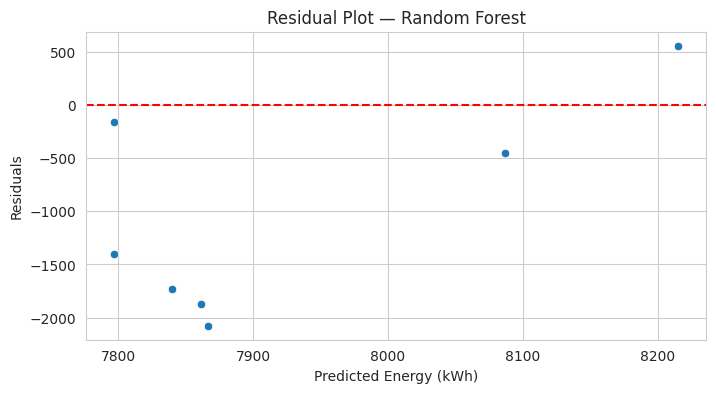

In [ ]:
residuals = y_test - test_preds
plt.figure(figsize=(8,4))
sns.scatterplot(x=test_preds, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Energy (kWh)")
plt.ylabel("Residuals")
plt.title("Residual Plot — Random Forest")
plt.show()


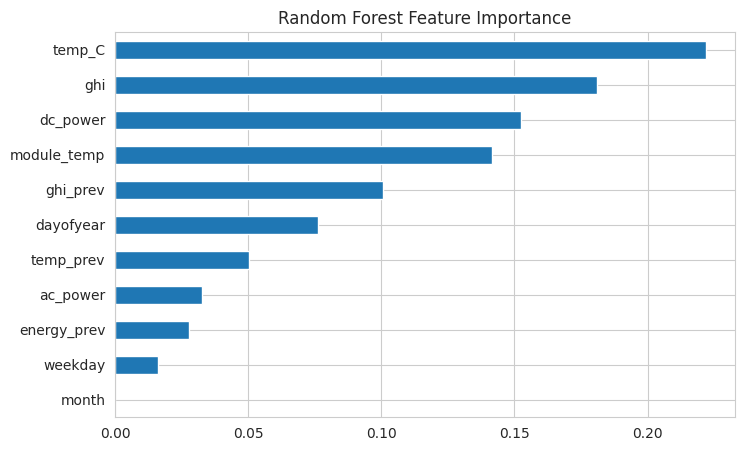

In [ ]:
feat_imp = pd.Series(rf.feature_importances_, index=feature_cols)
feat_imp.sort_values(ascending=True).plot(kind='barh', figsize=(8,5))
plt.title("Random Forest Feature Importance")
plt.show()


In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

xgb_preds = xgb.predict(X_test)
print("XGBoost R²:", r2_score(y_test, xgb_preds))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_preds)))


XGBoost R²: 0.46253018754886
XGBoost RMSE: 760.4341140649922


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(rf, X_train, y_train, cv=tscv, scoring='r2')
print("TimeSeries CV R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())


TimeSeries CV R² scores: [-14.41351933  -0.13101044  -2.41221762  -1.21996255   0.47326155]
Mean CV R²: -3.5406896776895076


In [ ]:
import joblib
joblib.dump(rf, "rf_solar_model_week3.pkl")
joblib.dump(X_train.columns.tolist(), "model_features_week3.pkl")
print("✅ Random Forest model and features saved")


✅ Random Forest model and features saved


In [ ]:
import joblib

# Load saved model
rf_model = joblib.load("rf_solar_model_week3.pkl")
model_features = joblib.load("model_features_week3.pkl")
print("✅ Model and features loaded.")


✅ Model and features loaded.


In [ ]:
def predict_next_day(model, features, new_data):
    """
    Predict next-day energy output.

    model     : trained RF or XGBoost model
    features  : list of feature column names
    new_data  : pandas DataFrame with same feature columns

    Returns predicted energy in kWh
    """
    # Ensure columns match
    new_X = new_data[features]
    preds = model.predict(new_X)
    return preds


In [ ]:
import pandas as pd

# Example new day input
new_day = pd.DataFrame({
    'ghi':[500],          # forecasted irradiation
    'ghi_prev':[480],     # previous day irradiation
    'temp_C':[35],        # forecasted temp
    'temp_prev':[34],     # previous day temp
    'module_temp':[40],   # forecasted module temp
    'dc_power':[180],     # optional previous dc power
    'ac_power':[175],     # optional previous ac power
    'dayofyear':[310],    # day number in year
    'month':[11],         # month
    'weekday':[2],        # 0=Monday
    'energy_prev':[1200]  # previous day's energy
})

predicted_energy = predict_next_day(rf_model, model_features, new_day)
print("Predicted next-day energy output (kWh):", predicted_energy[0])


Predicted next-day energy output (kWh): 9010.464045695273


In [ ]:
import pandas as pd

# Example new day input
new_day = pd.DataFrame({
    'ghi':[500],          # forecasted irradiation
    'ghi_prev':[480],     # previous day irradiation
    'temp_C':[35],        # forecasted temp
    'temp_prev':[34],     # previous day temp
    'module_temp':[40],   # forecasted module temp
    'dc_power':[180],     # optional previous dc power
    'ac_power':[175],     # optional previous ac power
    'dayofyear':[310],    # day number in year
    'month':[11],         # month
    'weekday':[2],        # 0=Monday
    'energy_prev':[1200]  # previous day's energy
})

predicted_energy = predict_next_day(rf_model, model_features, new_day)
print("Predicted next-day energy output (kWh):", predicted_energy[0])


Predicted next-day energy output (kWh): 9010.464045695273


In [ ]:
# Simple interactive input
ghi = float(input("Enter forecasted irradiation (GHI): "))
temp = float(input("Enter forecasted temperature (°C): "))
module_temp = float(input("Enter forecasted module temperature (°C): "))
energy_prev = float(input("Enter previous day's energy (kWh): "))

new_input = pd.DataFrame({
    'ghi':[ghi],
    'ghi_prev':[ghi],  # can set as same for demo
    'temp_C':[temp],
    'temp_prev':[temp],
    'module_temp':[module_temp],
    'dc_power':[0],    # optional if unknown
    'ac_power':[0],    # optional if unknown
    'dayofyear':[pd.Timestamp.today().dayofyear],
    'month':[pd.Timestamp.today().month],
    'weekday':[pd.Timestamp.today().weekday()],
    'energy_prev':[energy_prev]
})

pred = predict_next_day(rf_model, model_features, new_input)
print(f"Predicted next-day solar energy output: {pred[0]:.2f} kWh")


In [ ]:
# Suppose you have a DataFrame 'forecast_df' for multiple sites
predictions = predict_next_day(rf_model, model_features, forecast_df)
forecast_df['predicted_energy'] = predictions
forecast_df


In [ ]:
plt.figure(figsize=(8,4))
plt.bar(['Previous Day', 'Predicted Next Day'], [energy_prev, pred[0]], color=['blue','orange'])
plt.ylabel("Energy (kWh)")
plt.title("Previous vs Predicted Next-Day Solar Energy")
plt.show()
